In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
h5_path = r'K:\Mini2P\250306_DMM_DMM038_pillar\fm2\250306_DMM_DMM038_fm_2_preproc.h5'
data = fm2p.read_h5(h5_path)

In [19]:
def calc_modind(bins, tuning, fr, thresh=0.33):
    # modind of 0.33 is a doubling of firing rate relative

    # mean firing rate across the recording
    b = np.nanmean(fr)
    peak_val = np.nanmax(tuning)

    # print(b, peak_val)

    # diff over sum
    modind = (peak_val - b) / (peak_val + b)

    peak = np.nan
    if modind > 0.33:
        peak = bins[np.nanargmax(tuning)]

    return modind, peak

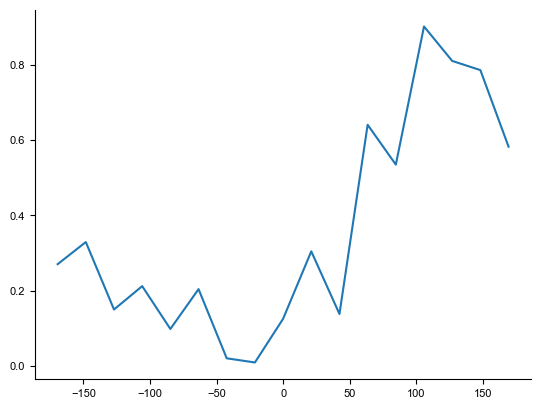

In [20]:
c_i = 1
go1_cent, ego1_tuning, ret1_err = fm2p.tuning_curve(spiketrains[c_i,:][np.newaxis,:], retinocentric[use], retino_bins)
plt.plot(ego1_cent, ego1_tuning[0,:])
modind, peak = calc_modind(ego1_cent, ego1_tuning, spiketrains[c_i,:])

In [23]:
print('modind={:.3}, peak={:.4}\N{DEGREE SIGN}'.format(modind, peak))

modind=0.431, peak=105.9°


In [29]:

spikes = data['oasis_spks'].copy()

egocentric = data['egocentric'].copy()
retinocentric = data['retinocentric'].copy()
pupil = data['pupil_from_head'].copy()
speed = data['speed'].copy()
speed = np.append(speed, speed[-1])
use = speed > 2.

ego_bins = np.linspace(-180, 180, 18)
retino_bins = np.linspace(-180, 180, 18)
pupil_bins = np.linspace(60, 95, 12)

lag_vals = [-3,-2,-1,0,1,2,3,4,5]

spiketrains = np.zeros([
    np.size(spikes,0),
    np.sum(use)
]) * np.nan

pdf = PdfPages('250306_DMM_DMM038_pillar_fm2_revcorrRFs_v03.pdf')

for c_i in range(np.size(spikes, 0)):

    fig, axs = plt.subplots(3, 9, dpi=300, figsize=(15,6))

    _maxtuning = 0

    for lag_ind, lag_val in enumerate(lag_vals):
        
        for cell_i in range(np.size(spikes,0)):
            spiketrains[cell_i,:] = np.roll(spikes[cell_i,:], shift=lag_val)[use]

        pupil_cent, pupil_tuning, pupil_err = fm2p.tuning_curve(spiketrains[c_i,:][np.newaxis,:], pupil[use], pupil_bins)
        ret1_cent, ret1_tuning, ret1_err = fm2p.tuning_curve(spiketrains[c_i,:][np.newaxis,:], retinocentric[use], retino_bins)
        ego1_cent, ego1_tuning, ego1_err = fm2p.tuning_curve(spiketrains[c_i,:][np.newaxis,:], egocentric[use], ego_bins)

        fm2p.plot_tuning(axs[0,lag_ind], pupil_cent, pupil_tuning, pupil_err, 'tab:blue', False)
        fm2p.plot_tuning(axs[1,lag_ind], ret1_cent, ret1_tuning, ret1_err, 'tab:orange', False)
        fm2p.plot_tuning(axs[2,lag_ind], ego1_cent, ego1_tuning, ego1_err, 'tab:green', False)

        lag_str = (1/7.49) * 1000 * lag_val

        Pmod, Ppeak = calc_modind(pupil_cent, pupil_tuning, spiketrains[c_i,:])
        if np.isnan(Ppeak):
            axs[0,lag_ind].set_title('{:.4}ms\nmod={:.3}'.format(lag_str, Pmod))
        else:
            axs[0,lag_ind].set_title('{:.4}ms\nmod={:.3} peak={:.4}\N{DEGREE SIGN}'.format(lag_str, Pmod, Ppeak))
        
        Rmod, Rpeak = calc_modind(ret1_cent, ret1_tuning, spiketrains[c_i,:])
        if np.isnan(Rpeak):
            axs[1,lag_ind].set_title('{:.4}ms\nmod={:.3}'.format(lag_str, Rmod))
        else:
            axs[1,lag_ind].set_title('{:.4}ms\nmod={:.3} peak={:.4}\N{DEGREE SIGN}'.format(lag_str, Rmod, Rpeak))
        
        Emod, Epeak = calc_modind(ego1_cent, ego1_tuning, spiketrains[c_i,:])
        if np.isnan(Epeak):
            axs[2,lag_ind].set_title('{:.4}ms\nmod={:.3}'.format(lag_str, Emod))
        else:
            axs[2,lag_ind].set_title('{:.4}ms\nmod={:.3} peak={:.4}\N{DEGREE SIGN}'.format(lag_str, Emod, Epeak))

        
        # axs[0,lag_ind].set_title('lag={:.3} ms'.format())
        axs[0,lag_ind].set_xlabel('pupil (deg)')
        axs[1,lag_ind].set_xlabel('retino (deg)')
        axs[2,lag_ind].set_xlabel('ego (deg)')

        for x in [np.nanmax(pupil_tuning+pupil_err), np.nanmax(ret1_tuning+ret1_err), np.nanmax(ego1_tuning+ego1_err)]:
            if x > _maxtuning:
                _maxtuning = x

    axs = axs.flatten()
    for ax in axs:
        ax.set_ylim([0, _maxtuning])
        ax.set_ylabel('sp/s')

    fig.suptitle('cell {}'.format(c_i))

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close()

pdf.close()

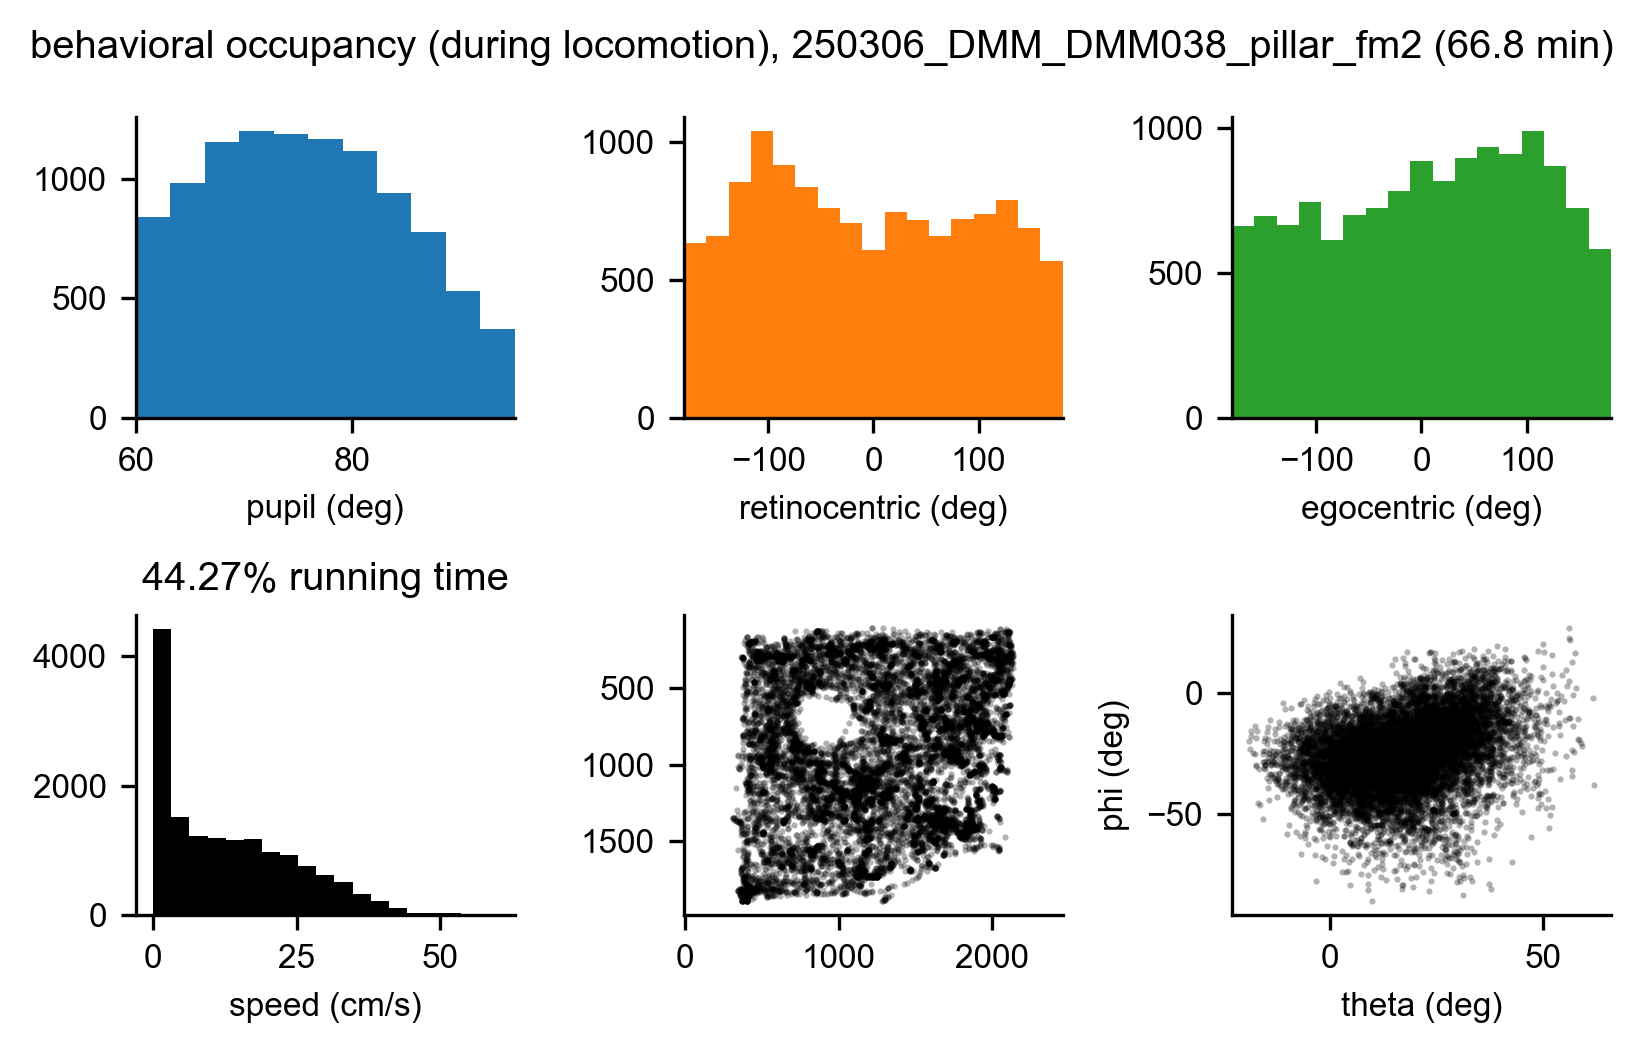

In [31]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, dpi=300, figsize=(5.5,3.5))

ax1.hist(data['pupil_from_head'][use], bins=pupil_bins, color='tab:blue')
ax1.set_xlabel('pupil (deg)')
ax1.set_xlim([pupil_bins[0], pupil_bins[-1]])

ax2.hist(data['retinocentric'][use], bins=retino_bins, color='tab:orange')
ax2.set_xlabel('retinocentric (deg)')
ax2.set_xlim([retino_bins[0], retino_bins[-1]])

ax3.hist(data['egocentric'][use], bins=ego_bins, color='tab:green')
ax3.set_xlabel('egocentric (deg)')
ax3.set_xlim([ego_bins[0], ego_bins[-1]])

speed = data['speed'].copy()
speed = np.append(speed, speed[-1])
use = speed > 1.

ax4.hist(speed, bins=np.linspace(0,60,20), color='k')
ax4.set_title('{:.4}% running time'.format((np.sum(use)/len(use))*100))
ax4.set_xlabel('speed (cm/s)')

ax5.plot(data['head_x'][use], data['head_y'][use], 'k.', ms=1, alpha=0.3)
ax5.invert_yaxis()
ax5.axis('equal')

ax6.plot(data['theta_interp'][use], data['phi_interp'][use], 'k.', ms=1, alpha=0.3)
ax6.set_xlabel('theta (deg)')
ax6.set_ylabel('phi (deg)')

fig.suptitle('behavioral occupancy (during locomotion), 250306_DMM_DMM038_pillar_fm2 ({:.3} min)'.format(data['twopT'][-1]/60))
fig.tight_layout()